# Controller Design with Pole Placement

### Steps:
1. Import the best model
2. Use **tf2zp( )** to see all poles & zeros location
3. Use **minreal( )** to see if pole zero cancellation
4. Find dominant pole(s) to reduce system order
5. Use a simple step responsee to show that the reduced order system can still correctly resemble the system

## Create ARMAX model
The ARMAX model is based on the paper "Heat Exchanger Model (Data-driven modelling)"

In [1]:
num = [0.0001701, 0.0001295];          % B
den = [1, -0.2492, -0.7469, 0, 0, 0];  % A
Ts = 0.01;
sys = tf(num, den, Ts)


sys =
 
     0.0001701 z + 0.0001295
  -----------------------------
  z^5 - 0.2492 z^4 - 0.7469 z^3
 
Sample time: 0.01 seconds
Discrete-time transfer function.




### Pole-Zero Cancellation
Can use this to simplify the model if there exists pole-zero cancellation

In [2]:
sys = minreal(sys, 1e-3)   % in this case, it does not


sys =
 
     0.0001701 z + 0.0001295
  -----------------------------
  z^5 - 0.2492 z^4 - 0.7469 z^3
 
Sample time: 0.01 seconds
Discrete-time transfer function.




### Check system poles, zeros, DC gain
Use function **[z, p, k] = tf2zp(num, den)** ([link](https://se.mathworks.com/help/signal/ref/tf2zp.html))

In [3]:
[ze, p, k] = tf2zp(num, den)


ze =

   -0.7613


p =

         0
         0
         0
    0.9978
   -0.7486


k =

   1.7010e-04




## Reduce System Order
Two ways: <br>
1. Find dominant poles
2. Use $balred()$ function

### Sol.01: Find Dominant Poles to Reduce System Order
From the output above, the system poles are at 0, 0, 0, 0.9978, -0.7486 <br>
The dominant poles in a discrete system are the ones that are closest to the unit circle <br>
Thus, the dominant poles are at 0.9978, -0.7486. The system can thus be reduced to 2nd-order

In [4]:
z = tf('z', Ts);
sys_dominant = k*(z+0.7613)/((z-0.9978)*(z+0.7486))  % remember to include the DC gain (k)


sys_dominant =
 
  0.0001701 z + 0.0001295
  -----------------------
  z^2 - 0.2492 z - 0.747
 
Sample time: 0.01 seconds
Discrete-time transfer function.




#### To proof that the reduced-order system is still a good approximate of the original system
Easy example: <br>
* step( ): for plotting system response
* stepinfo( ): retrieve information

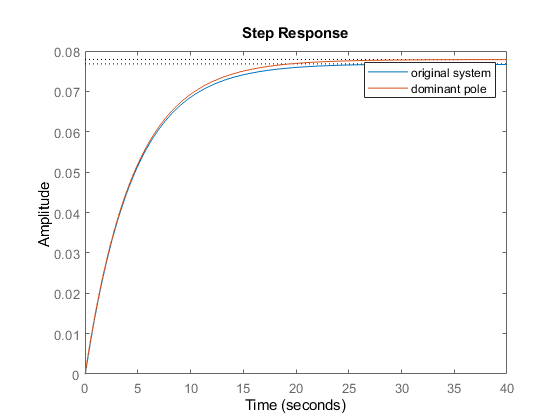

In [5]:
step(sys, sys_dominant)
legend({'original system', 'dominant pole'})

From the output below it is clear that ***sys*** and ***sys_dominant*** are almost identical

In [6]:
S = stepinfo(sys)
display('--------------------------')
S = stepinfo(sys_dominant)


S = 

  struct with fields:

        RiseTime: 9.8400
    SettlingTime: 17.5600
     SettlingMin: 0.0692
     SettlingMax: 0.0767
       Overshoot: 0
      Undershoot: 0
            Peak: 0.0767
        PeakTime: 27.5900

--------------------------

S = 

  struct with fields:

        RiseTime: 9.9800
    SettlingTime: 17.7700
     SettlingMin: 0.0701
     SettlingMax: 0.0779
       Overshoot: 0
      Undershoot: 0
            Peak: 0.0779
        PeakTime: 43.7900




#### This step is just to convert the poles to continuous time. The rest is just to double check if the converted poles are correct.


pole_cont =

   1.0e+03 *

   -1.3911
   -0.0002


zero_cont =

   1.0e+03 *

   -1.4757
    0.2000


sys_cont_proof =
 
  s^2 + 1676 s + 295140
  ---------------------
  s^2 + 1391 s + 278.2
 
Continuous-time transfer function.


k_d =

    0.0779


k_c =

   1.0608e+03


sys_cont_proof =
 
      s^2 + 1676 s + 295140
  ------------------------------
  1061 s^2 + 1.476e06 s + 295140
 
Continuous-time transfer function.




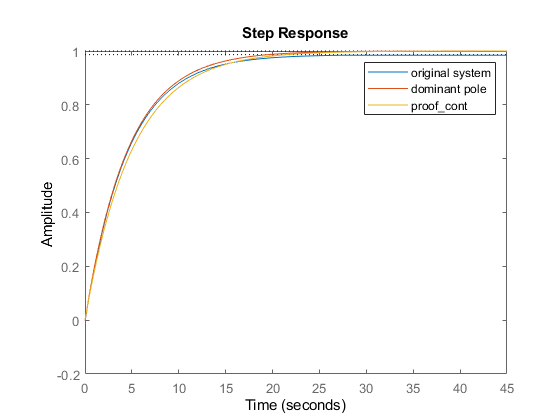

In [7]:
sys_cont = d2c(sys_dominant, 'tustin');

pole_cont = pole(sys_cont)
zero_cont = zero(sys_cont)

s = tf('s');
%sys_cont_proof = ((s-0.5)*(s+3.6894))/((s+0.0006)*(s+3.477))    % Ts = 4    , P = -0.0006, -3.477  , Z = 0.5   , -3.6894    
%sys_cont_proof = ((s-2)*(s+14.7574))/((s+0.0022)*(s+13.9109))   % Ts = 1    , P = -0.0022, -13.9109, Z = 2     , -14.7574
sys_cont_proof = ((s+1475.7)*(s+200))/((s+1391.1)*(s+0.2))       % Ts = 0.01 , P = -0.2   , -1391.1 , Z = -2000 , -1475.7
%sys_cont_proof = ((s+14757)*(s+20000))/((s+13911)*(s+2))        % Ts = 0.001, P = -2     , -13911  , Z = -20000, -14757

% check dc gain
% k = DC gain of original system
k_d = dcgain(sys_cont) % k_d : sys_dominant = sys_cont
k_c = dcgain(sys_cont_proof)
sys_cont_proof = sys_cont_proof/k_c

step((sys/k_d), (sys_cont/k_d), sys_cont_proof)
legend({'original system', 'dominant pole', 'proof_cont'})

#### From the chart above we can confirm that:
1. Choosing the dominant pole to reduce the system order is possible (sys_dominant)
2. Transform the discrete transfer function (sys_dominant) into continuous time is possible (sys_cont, sys_cont_proof)
3. We also retrieve the dominant poles in continuous time are at -0.0006 and -3.4777

### Sol.02: Use $balred()$ function
<div class="alert-warning">
    Note that this step <strong>should ONLY be conducted in MATLAB </strong> (<a href="https://se.mathworks.com/help/control/ref/modelreducer-app.html"> Click Here</a>)
</div>

1. Type $modelReducer$ in the command window to trigger the toolbox <br>
2. Matlab gives **Discrete TF**
3. Jupyter Lab gives **Discrete SS**

In [ ]:
System = sys; % Define System to reduce
Order = 2;
 
% Create option set for balred command
Options = balredOptions();
 
% Compute reduced order approximation
ReducedSystem = balred(System,Order,Options);
 
% Create comparison plot
bode(System,ReducedSystem);
legend('System', 'ReducedSystem');

## Pole Placement
In this particular case, the system is reduced to second order.    <br>

### Part 1: PI Controller

1. A general form of a second order system can be shown as $G_p$:  <br>
> $G_p = \frac{B}{A} = \frac{b_{1}z + b_{0}}{z^{2}+a_{1}z+a_{0}}$  <br>

In [8]:
% Retreive coefficients of the plant
Gp = sys_dominant;
[num, den] = tfdata(Gp);
b1 = num{1}(2);  b0 = num{1}(3);
a1 = den{1}(2);  a0 = den{1}(3);

2. A general form of a PI controller in discrete time can be shown as $G_c$: <br>
> $G_c = \frac{S}{R} = P + I \frac{T_s}{z-1}$                                <br>

3. Diophantine equation $A_{cl}$:                                                        <br>
> $A_{cl} = AR+BS = ( z^{2}+a_{1}z+a_{0} )( z-1 ) + ( b_{1}z + b_{0} )( Pz+IT_{s}-P )$   <br>

4. Desired equation $A_{d} = A_{m}(z)A_{o}(z)$: <br>
> $deg(A_{cl}) = deg(A_{d})  = 3 $              <br>
> $deg(A_{m}) = deg(G_{p})   = 2 $              <br>
> $deg(A_{o}) = deg(A_{d}) - deg(A_{m}) = 1$    <br>

$\rightarrow$ Choose poles (In Continuous Domain): <br>
$A_m \rightarrow (w_m, \zeta_m)$ <br>
$A_o \rightarrow (w_o)$ 

In [9]:
%--- A_m ------
w_m = 35;
zeta_m = 0.7;

%--- A_o ------
w_o = 80;

5. Designing $A_{d}$ and $A_{o}$:                                                <br>
* A first order general discrete form is:                                        <br>
> $A_{o} = z-e^{-w_{o}T_{s}} = p_0$                                              <br>

* A second order general discrete form is:                                             <br>
> $A_{m} = (z-z_{1})(z-z_{2}) = z^2-(z_{1}+z_{2})+z_{1}z_{2} = z^2- p_2 z+ p_1 $       <br>
> $p_2 = z_{1} + z_{2} = 2e^{-\zeta_{m} w_{m} T_{s}} \cos(w_{m}T_{s} \sqrt{1-\zeta_{m}^2}) $   <br>
> $p_1 = z_{1}z_{2} = e^{-2\zeta_{m} w_{m}T_{s}}$                                          <br>

Note that choosing a pole $w_{o}$ at continuous time is associating to the pole $e^{-w_{o}T_{s}}$ in discrete time

$\rightarrow$ Convert cont poles to discrete poles

In [ ]:
%--- A_m ------
p2 = 2*exp(-zeta_m*w_m*Ts)*cos(w_m*Ts*sqrt(1-(zeta_m)^2)); % z1 + z2
p1 = exp(-2*zeta_m*w_m*Ts); % z1*z2

%--- A_o ------
p0 = exp(-w_o*Ts);

In [ ]:
% Diophantine Eqn A_cl = AR + BS
syms P I z
A_cl = (z^2+a1*z+a0)*(z-1) + (b1*z+b0)*(P*z + I*Ts - P);
A_d = (z^2-p2*z+p1)*(z-p0);
A_cl_c = fliplr(coeffs(A_cl, z)); % retreive coeficients
A_d_c = fliplr(coeffs(A_d, z));     % retreive coeficients

In [ ]:
% Solve Eqn
equ1 = A_cl_c(2) == A_d_c(2); % z^2
equ2 = A_cl_c(3) == A_d_c(3); % z^1
equ3 = A_cl_c(4) == A_d_c(4); % z^0

sol = solve([equ1, equ2, equ3], [P, I]);

P = double(sol.P)
I = double(sol.I)

### Part 2: PID Controller

<div class="alert-info">
Note that Num of Diophantine Eqn > Num of Control Parameters. In this case, the system is unsolvable <br>
Solution: <br>
Add a Derivative with low pass filter
</div>

6. Add a low pass filter to our PI controller in discrete time $G_c$:          <br>
> $G_c = \frac{S}{R} = P + I \frac{T_s}{z-1} + D \frac{(z-1)N}{z-1+NTs}$       <br>
> where N is the low pass filter 

$A_{cl}$ thus becomes a 4th-order polynomial. This results in both $A_{m}$ and $A_{o}$ become 2nd-order. <br>
$A_{d} = A_{m}A_{o} = (z^2-p_3z+p_2)(z^2-p_1z+p_0)$, where
> $p_3 = 2e^{-\zeta_{m} w_{m} T_{s}} \cos(w_{m}T_{s} \sqrt{1-\zeta_{m}^2}) $   <br>
> $p_2 = e^{-2\zeta_{m} w_{m}T_{s}}$                                           <br>
> $p_1 = 2e^{-\zeta_{o} w_{o} T_{s}} \cos(w_{o}T_{s} \sqrt{1-\zeta_{o}^2}) $   <br>
> $p_0 = e^{-2\zeta_{o} w_{o}T_{s}}$                                           <br>

$\rightarrow$ Thus, we have to choose $(w_m, \zeta_m)$ and $(w_o, \zeta_o)$

In [10]:
%--- A_m ------
w_m = 10;
zeta_m = 2;
%--- A_o ------
w_o = 10;
zeta_o = zeta_m;

p3 = 2*exp(-zeta_m*w_m*Ts)*cos(w_m*Ts*sqrt(1-(zeta_m)^2));
p2 = exp(-2*zeta_m*w_m*Ts);
p1 = 2*exp(-zeta_o*w_o*Ts)*cos(w_o*Ts*sqrt(1-(zeta_o)^2));
p0 = exp(-2*zeta_o*w_o*Ts);

In [11]:
fprintf('The original cont. poles are: -0.2 and -1391.1 \n');
fprintf('The chosen cont. poles are: %d and %d \n', -w_m, -w_o);

% Convert to associating discrete poles
w_m_d = exp(-zeta_m*w_m*Ts);
w_o_d = exp(-zeta_o*w_o*Ts);

chosen_disc_poles = ['The chosen disc. poles are: ', num2str(w_m_d), ' and ', num2str(w_o_d)];
disp(chosen_disc_poles)

The original cont. poles are: -0.2 and -1391.1 
The chosen cont. poles are: -10 and -10 
The chosen disc. poles are: 0.81873 and 0.81873



In [12]:
% Diophantine Eqn A_cl = AR + BS
syms P I D N z
A_cl = (z^2+a1*z+a0)*(z-1)*(z-1+N*Ts) + (b1*z+b0)*((z-1)*(z-1+N*Ts)*P+(z-1+N*Ts)*I*Ts+(z-1)^2*D*N);
A_d = (z^2-p3*z+p2)*(z^2-p1*z+p0);
A_cl_c = fliplr(coeffs(A_cl, z)); % retreive coeficients
A_d_c = fliplr(coeffs(A_d, z));   % retreive coeficients

% Solve Eqn
equ1 = A_cl_c(2) == A_d_c(2); % z^3
equ2 = A_cl_c(3) == A_d_c(3); % z^2
equ3 = A_cl_c(4) == A_d_c(4); % z^1
equ4 = A_cl_c(5) == A_d_c(5); % z^0

sol = solve([equ1, equ2, equ3, equ4], [P, I, D, N]);

P = double(sol.P)
I = double(sol.I)
D = double(sol.D)
N = double(sol.N)


P =

  -12.9563


I =

   -0.1423


D =

  -58.3923


N =

  -1.5902e+04




<div class="alert-success">
Now we solve the solution for P, I, D, N
</div>

In [13]:
z = tf('z', Ts);
Gc = P + I*Ts/(z-1) + D*(N)/(1+(N*Ts)/(z-1))
%Gc = minreal(Gc, 1e-3)


Gc =
 
  9.285e05 z^2 - 1.855e06 z + 9.265e05
  ------------------------------------
           z^2 - 161 z + 160
 
Sample time: 0.01 seconds
Discrete-time transfer function.




#### Calculate T(z)
$T = t_o * A_o(z) = \frac{A_m(1)}{B(1)}*A_o(z)$

In [14]:
t_o = (1-p3+p2)/(b1+b0);
A_o = [1, -p1, p0];
T = t_o*A_o;
R = [1, N*Ts-2, 1-N*Ts];

In [15]:
fprintf('##################################### \n');
fprintf('Plant Model Gp: \n');
Gp

fprintf('##################################### \n');
fprintf('FB Controller Gc: \n');
Gc

fprintf('##################################### \n');
fprintf('FF Controller Gff: \n');
Gff = tf(T, R, Ts)

fprintf('##################################### \n');
fprintf('Full state FB Controller Gyr: \n');
Gyr = minreal(Gff*Gp/(1+Gc*Gp), 1e-3)

##################################### 
Plant Model Gp: 

Gp =
 
  0.0001701 z + 0.0001295
  -----------------------
  z^2 - 0.2492 z - 0.747
 
Sample time: 0.01 seconds
Discrete-time transfer function.

##################################### 
FB Controller Gc: 

Gc =
 
  9.285e05 z^2 - 1.855e06 z + 9.265e05
  ------------------------------------
           z^2 - 161 z + 160
 
Sample time: 0.01 seconds
Discrete-time transfer function.

##################################### 
FF Controller Gff: 

Gff =
 
  27.49 z^2 - 45.69 z + 18.43
  ---------------------------
       z^2 - 161 z + 160
 
Sample time: 0.01 seconds
Discrete-time transfer function.

##################################### 
Full state FB Controller Gyr: 

Gyr =
 
   0.004676 z + 0.00356
  ----------------------
  z^2 - 1.662 z + 0.6703
 
Sample time: 0.01 seconds
Discrete-time transfer function.




#### 

Recall that:
The chosen disc. poles are: 0.81873 and 0.81873

z_yr =

  0x1 empty double column vector


p_yr =

    0.9736
    0.6885


k_yr =

    0.0047




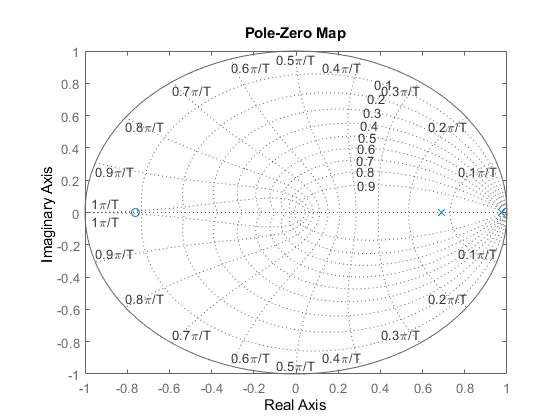

In [16]:
disp('Recall that:')
disp(chosen_disc_poles)

[num_yr, den_yr] = tfdata(Gyr);

b1 = num_yr{1}(1);  b0 = num_yr{1}(2);
a2 = den_yr{1}(1);  a1 = den_yr{1}(2);  a0 = den_yr{1}(3);

B_yr = [b1, b0];
A_yr = [a2, a1, a0];
[z_yr, p_yr, k_yr] = tf2zp(B_yr, A_yr)

pzmap(Gyr)
grid on;


dc_gain_sys =

    0.0768


dc_gain_dominant =

    0.0779


dc_gain_Gyr =

    1.0003




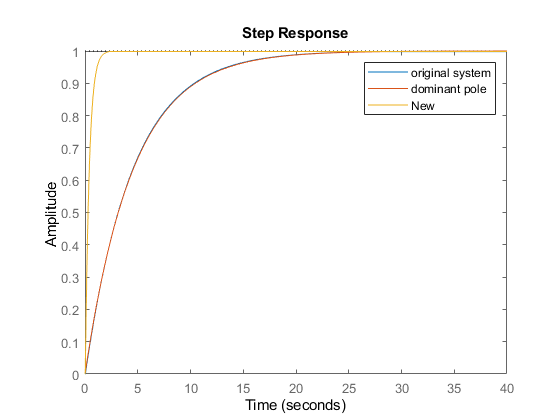

In [17]:
dc_gain_sys = dcgain(sys)
dc_gain_dominant = dcgain(sys_dominant)
dc_gain_Gyr = dcgain(Gyr)

step(sys/dc_gain_sys, sys_dominant/dc_gain_dominant, Gyr)
legend({'original system', 'dominant pole', 'New'})

### Part 3: Direct Discrete PID Controller